# Importing packages 

In [23]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Loading the dataset

In [24]:
# Load the dataset using pandas
d = pd.read_csv('data/auto-mpg.csv')

# Preprocess the dataset

In [25]:
# Exclude non-numeric columns
numeric_columns = d.select_dtypes(include=np.number).columns
d_numeric = d[numeric_columns]

In [26]:
# Split the dataset into features (X) and target variable (Y)
X = d_numeric.drop("mpg", axis=1)
y = d_numeric["mpg"]

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
d.head(10)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
5,15.0,8,429.0,198,4341,10.0,70,1,ford galaxie 500
6,14.0,8,454.0,220,4354,9.0,70,1,chevrolet impala
7,14.0,8,440.0,215,4312,8.5,70,1,plymouth fury iii
8,14.0,8,455.0,225,4425,10.0,70,1,pontiac catalina
9,15.0,8,390.0,190,3850,8.5,70,1,amc ambassador dpl


# Set the hyperparameters for GBDT 


In [28]:
n_estimators = 10
learning_rate = 0.1

# Initialize the ensemble predictions and lists to store the evaluation metrics

In [29]:
ensemble_predictions = np.zeros_like(y_train)

In [30]:
train_mse = []
test_mse = []

# Build the GBDT ensemble

In [31]:
# Initialize the GBDT model

gbdt = GradientBoostingRegressor()

In [32]:
from sklearn.tree import DecisionTreeRegressor

# Train each tree in the ensemble
for i in range(n_estimators):
    # Calculate the negative gradient (pseudo-residuals)
    negative_gradient = y_train - ensemble_predictions

    # Fit a regression tree to the pseudo-residuals
    tree = DecisionTreeRegressor(max_depth=3)
    tree.fit(X_train, negative_gradient)

    # Update the ensemble predictions by adding the predictions of the new tree
    ensemble_predictions += learning_rate * tree.predict(X_train)

    # Make predictions on the training set
    train_predictions = ensemble_predictions.copy()

    # Make predictions on the testing set
    test_predictions = np.zeros_like(y_test)
    for j in range(i+1):
        test_predictions += learning_rate * tree.predict(X_test)

    # Calculate evaluation metrics
    train_mse.append(mean_squared_error(y_train, train_predictions))
    test_mse.append(mean_squared_error(y_test, test_predictions))

# Plot the learning curve

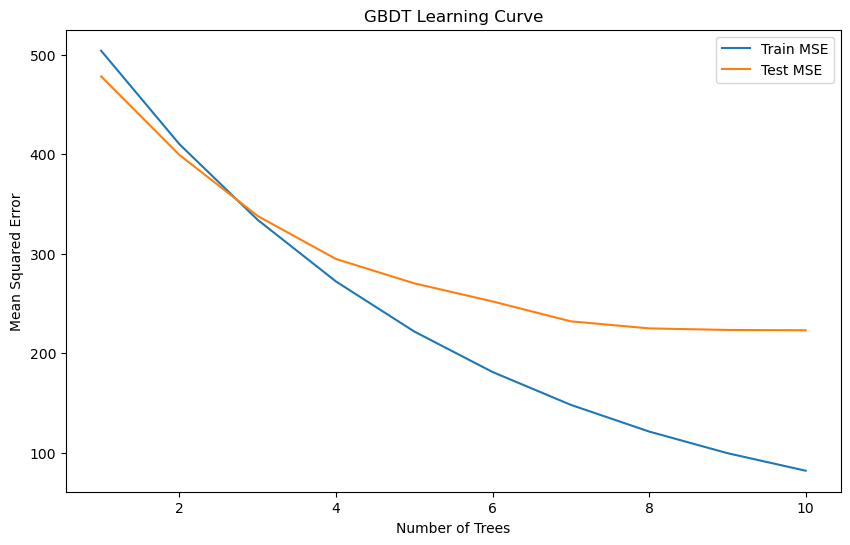

In [33]:
# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_estimators+1), train_mse, label='Train MSE')
plt.plot(range(1, n_estimators+1), test_mse, label='Test MSE')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Squared Error')
plt.title('GBDT Learning Curve')
plt.legend()
plt.show()

# Predictions on the testing set

In [34]:
n_iterations = 10  # Define the number of iterations

for i in range(n_iterations):
    # Calculate the negative gradient (pseudo-residuals) of the loss function
    negative_gradient = y_train - ensemble_predictions

    # Fit a regression tree to the pseudo-residuals
    tree = DecisionTreeRegressor(max_depth=3)
    tree.fit(X_train, negative_gradient)

    # Update the ensemble predictions by adding the predictions of the new tree
    ensemble_predictions += learning_rate * tree.predict(X_train)


In [35]:
# Initialize the ensemble predictions on the testing set
ensemble_predictions_test = np.zeros_like(y_test)

# Make predictions for each tree in the ensemble on the testing set
for i in range(n_estimators):
    ensemble_predictions_test += learning_rate * tree.predict(X_test)

# Evaluate the model

In [36]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test, ensemble_predictions_test)
r2 = r2_score(y_test, ensemble_predictions_test)

# Print the evaluation metrics
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 435.14649617331423
R^2 Score: -7.093272789188594


# Improving model performance

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Feature Engineering
# Example: Creating polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Model Initialization
model = make_pipeline(GradientBoostingRegressor())

# Hyperparameter Tuning
# Example: Grid Search with cross-validation
param_grid = {'gradientboostingregressor__n_estimators': [100, 200, 300],
              'gradientboostingregressor__learning_rate': [0.1, 0.05, 0.01]}
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_poly, y)

# Best Model
best_model = grid_search.best_estimator_

# Cross-Validation
# Example: 5-fold cross-validation
cv_scores = cross_val_score(best_model, X_poly, y, cv=5, scoring='neg_mean_squared_error')
mse_scores = -cv_scores
r2_scores = cross_val_score(best_model, X_poly, y, cv=5, scoring='r2')

# Evaluate Performance
mean_mse = mse_scores.mean()
mean_r2 = r2_scores.mean()

# Print Results
print("Mean Squared Error:", mean_mse)
print("R^2 Score:", mean_r2)


Mean Squared Error: 8.264362510723268
R^2 Score: 0.7813174308242076


In this example, we perform feature engineering using polynomial features. We initialize a Gradient Boosting Regressor model and tune its hyperparameters using grid search with cross-validation. Then, we evaluate the model's performance using 5-fold cross-validation and calculate the mean MSE and R^2 scores.